# Convolutional neural networks for artistic style transfer
This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576))that demonstrates how to use neural networks to transfer artistic style from one image onto another.

In [1]:
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def upload_files():
  from google.colab import files
  uploaded = files.upload()
  for k, v in uploaded.items():
    open(k, 'wb').write(v)
  return list(uploaded.keys())
upload_files()

Saving Robert_Delaunay,_1906,_Portrait.jpg to Robert_Delaunay,_1906,_Portrait.jpg


['Robert_Delaunay,_1906,_Portrait.jpg']

In [181]:
upload_files()

Saving frida_kahlo.jpg to frida_kahlo.jpg


['frida_kahlo.jpg']

## Load and preprocess the content and style images

Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

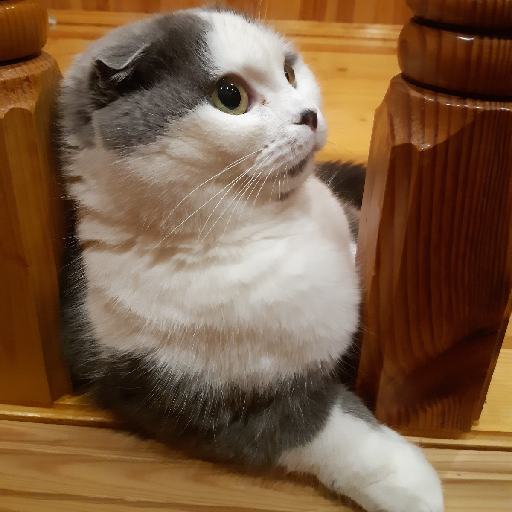

In [182]:
height = 512
width = 512

content_image_path = 'my_cat.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((width, height))
content_image

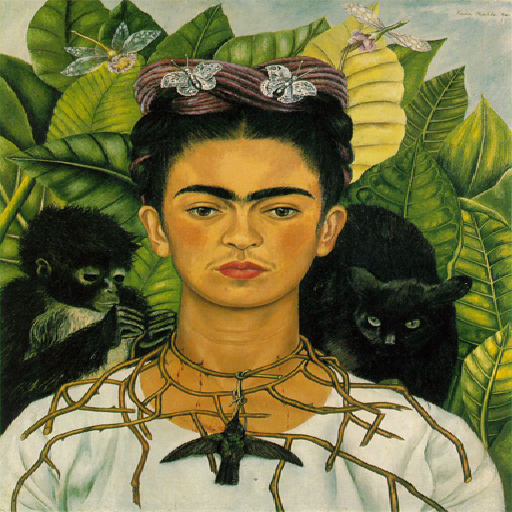

In [183]:
style_image_path = 'frida_kahlo.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((width, height))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [184]:
content_array_row = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array_row, axis=0)
print(content_array.shape)

style_array_row = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array_row, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


We need to perform two transformations:
​
1. Subtract the mean RGB value from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* .

In [0]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the combination image that retains the content of the content image while incorporating the style of the style image.

In [0]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

Сoncatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

In [0]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis=0)

## Reuse a model pre-trained for image classification to define loss functions

The core idea introduced by is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [0]:
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers.

In [189]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_6/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_6/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_6/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_6/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_6/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_6/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_6/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_6/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_6/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_6/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_6/Relu:0' shape=(3, 64, 64, 51

Loss function that we want to minimise can be decomposed into three distinct parts: the *content loss*, the *style loss* and the *total variation loss*.
The relative importance of these terms are determined by a set of scalar weights. These are arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output.

In [0]:
content_weight = 0.025
style_weight = 5
total_variation_weight = 1

We'll now use the feature spaces provided by specific layers of our model to define these 3 loss functions.

In [0]:
loss = backend.variable(0.)

### The content loss

For the content loss we need to use `block2_conv2`.

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [192]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

### The style loss

This is where things start to get a bit intricate.

For the style loss, we first define something called a Gram matrix. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content.
The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

In [0]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

### The total variation loss

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.


In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

## Define needed gradients and solve the optimisation problem

The goal was to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

Defining the gradients.

In [0]:
grads = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [0]:
def plot_images(content_image, style_image, mixed_image):
    fig, axes = plt.subplots(1, 3, figsize=(10, 10))

    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    # Use interpolation to smooth pixels?
    smooth = False
    
    # Interpolation type.
    if smooth:
        interpolation = 'sinc'
    else:
        interpolation = 'nearest'

    ax = axes.flat[0]
    ax.imshow(content_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Content")

    ax = axes.flat[1]
    ax.imshow(mixed_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Mixed")

    ax = axes.flat[2]
    ax.imshow(style_image / 255.0, interpolation=interpolation)
    ax.set_xlabel("Style")

    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

In [0]:
def preprocessed_mixed_data(x):
  y = x.reshape((height, width, 3))
  y = y[:, :, ::-1]
  y[:, :, 0] += 103.939
  y[:, :, 1] += 116.779
  y[:, :, 2] += 123.68
  y = np.clip(y, 0, 255)
  return y

Now everything is ready to solve the optimization problem. For the combined image, we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (the quasi-Newtonian algorithm, which converges much faster than the standard gradient descent) to iteratively improve it.

The algorithm stops after 10 iterations, because the losses cease to significantly decrease.

Start of iteration 0
Current loss value: 57448340000.0
Iteration 0 completed in 8s


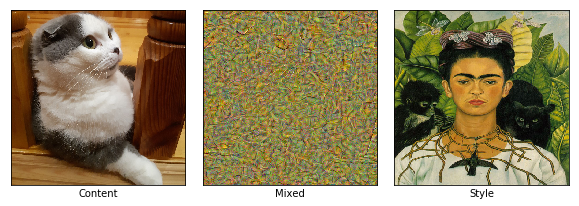

Start of iteration 1
Current loss value: 29811794000.0
Iteration 1 completed in 6s


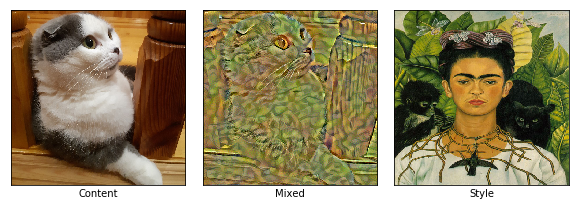

Start of iteration 2
Current loss value: 21992686000.0
Iteration 2 completed in 7s


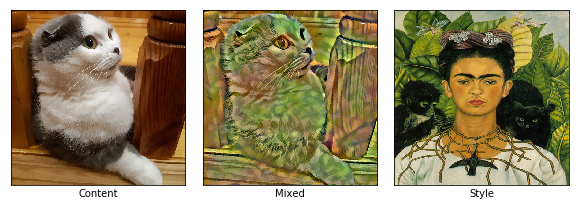

Start of iteration 3
Current loss value: 18686333000.0
Iteration 3 completed in 7s


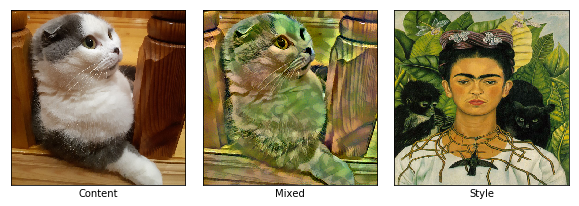

Start of iteration 4
Current loss value: 16796109000.0
Iteration 4 completed in 7s


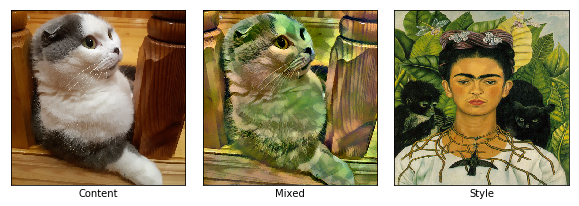

Start of iteration 5
Current loss value: 15257761000.0
Iteration 5 completed in 7s


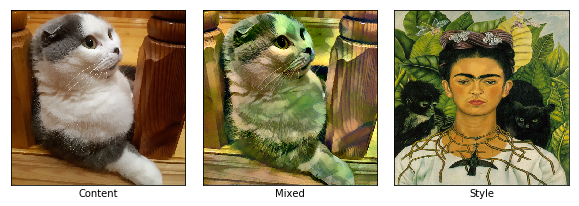

Start of iteration 6
Current loss value: 14458827000.0
Iteration 6 completed in 7s


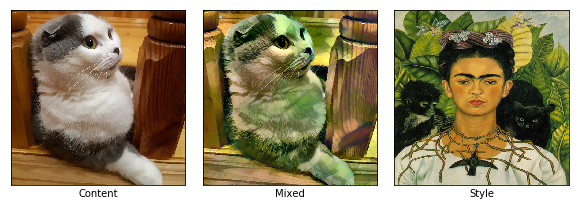

Start of iteration 7
Current loss value: 13935107000.0
Iteration 7 completed in 7s


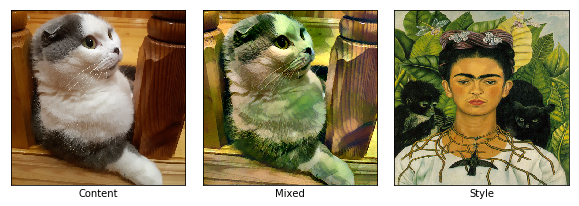

Start of iteration 8
Current loss value: 13630279000.0
Iteration 8 completed in 7s


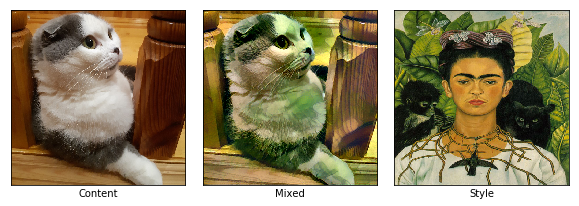

Start of iteration 9
Current loss value: 13412080000.0
Iteration 9 completed in 7s


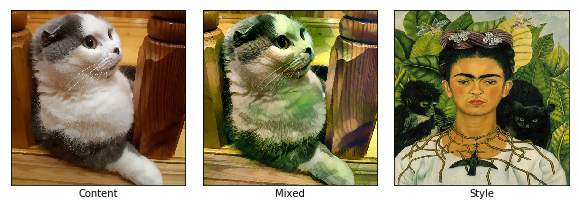

In [200]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 10

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))
    plot_images(preprocessed_mixed_data(content_array.copy()),
                preprocessed_mixed_data(style_array.copy()),
                preprocessed_mixed_data(x.copy()))

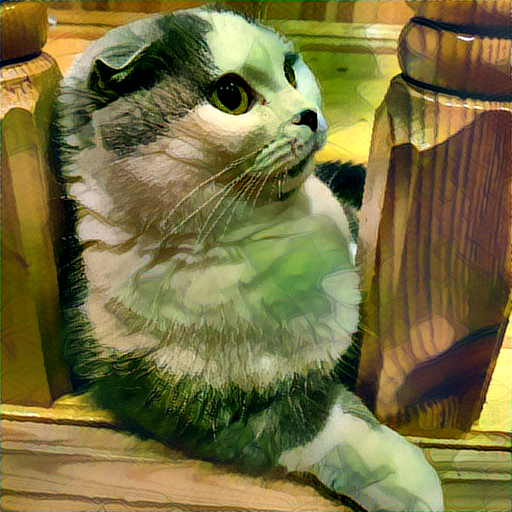

In [203]:
output_image_path = "my_style_cat_frida_kahlo.jpg"
l = preprocessed_mixed_data(x.copy()).astype('uint8')

output_image = Image.fromarray(l)
output_image.save(output_image_path)
output_image

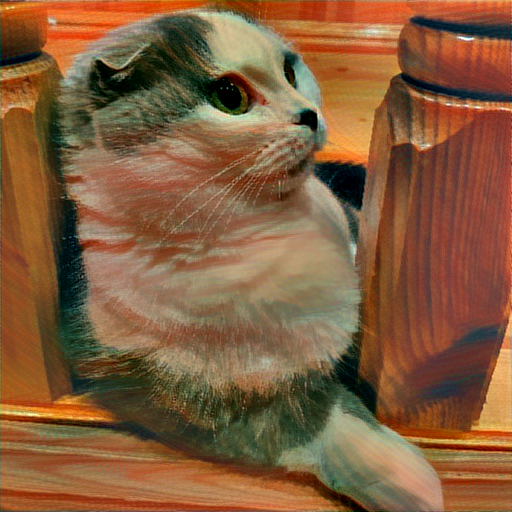

In [106]:
output_image_path = "my_style_cat_the_scream_5.jpg"
l = preprocessed_mixed_data(x.copy()).astype('uint8')

output_image = Image.fromarray(l)
output_image.save(output_image_path)
output_image

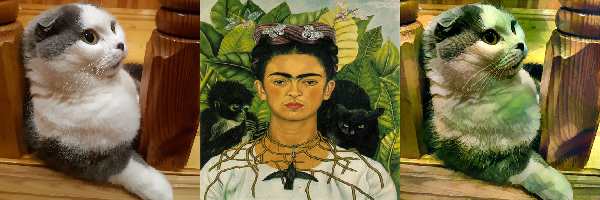

In [204]:
# Visualizing combined results
combined_image_path = "my_cat_result_frida_kahlo_2.jpg"
combined = Image.new("RGB", (200*3, 200))
x_offset = 0
for image in map(lambda x: x.resize((200, 200)), map(Image.open, [content_image_path, style_image_path, output_image_path])):
    combined.paste(image, (x_offset, 0))
    x_offset += 200
combined.save(combined_image_path)
combined